In [125]:
import sys
import glob
import fnmatch
from os import listdir
from os.path import join, isfile

import numpy as np
from numpy import float32, int32, uint8, dtype, genfromtxt

import pandas 

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [166]:
# Relevant directories

labels = [16,64,8,32,2,4,65,66,33,67,34,17,69,70,35,71,9,18,72,36,73,74,37,75,19,76,38,77,39,78,79,20,5,40,80,10,81,82,83,84,85,86,11,22,23,24,12,3,6,49,50,25,51,13,52,26,53,27,54,55,56,28,7,14,57,58,29,59,30,60,15,61,31,62,63]

neuron_list_file="/nrs/saalfeld/john/projects/flyChemStainAtlas/eval/prefix_list_by_neuron.txt"
f=open(neuron_list_file)
tmp=f.read().splitlines()
f.close()
neurons = [ n.split(' ') for n in tmp ]
print neurons

print ' '
jfrcDir = '/nrs/saalfeld/john/projects/flyChemStainAtlas/eval/ants_jfrc2/evalComp'
print jfrcDir

grpDir = '/nrs/saalfeld/john/projects/flyChemStainAtlas/eval_f/ants-el-ag_owl/evalComp'
print grpDir

# a = []
# a += 'a'
# a += ['b','c']
# print a 

#glob.glob('/nrs/saalfeld/john/projects/flyChemStainAtlas/eval/ants_jfrc2/evalComp/*_B[0-9]_SAME_labelHist_[0-9]*.csv')

[['20161102_32_C1', '20161102_32_C3', '20161102_32_D1', '20161102_32_D2', '20161102_32_E1', '20161102_32_E3', '20161220_31_I1', '20161220_31_I2', '20161220_31_I3', '20161220_32_C1', '20161220_32_C3'], ['20170223_32_A2', '20170223_32_A3', '20170223_32_A6'], ['20170223_32_E1', '20170223_32_E2', '20170223_32_E3'], ['20170301_31_B1', '20170301_31_B3', '20170301_31_B5']]
 
/nrs/saalfeld/john/projects/flyChemStainAtlas/eval/ants_jfrc2/evalComp
/nrs/saalfeld/john/projects/flyChemStainAtlas/eval_f/ants-el-ag_owl/evalComp


In [149]:
jfrc_hist_sizes = pandas.read_csv( '/nrs/saalfeld/john/projects/flyChemStainAtlas/eval/ants_jfrc2/evalComp/totals.csv', header=None, names=['pair','count'] )
grp_hist_sizes = pandas.read_csv( '/nrs/saalfeld/john/projects/flyChemStainAtlas/eval_f/ants-el-ag_owl/evalComp/totals.csv', header=None, names=['pair','count'] )


In [164]:
res = jfrc_hist_sizes[ jfrc_hist_sizes.pair=='20161220_31_I1-20161220_31_I3_SAME_labelHist_78.csv' ]['count']
#print res.tolist()[0]

res = jfrc_hist_sizes.as_matrix(columns=['count'])
print res.shape

np.count_nonzero( res <= 40 )

# n, bins, patches = plt.hist( res, 2000, normed=1 )
# plt.axis([ 20, 1000, 0.0, 0.0012 ])

(9728, 1)


984

In [214]:
# Functions

def getCount( df_counts, pair_name ):
    res = df_counts[ df_counts.pair == pair_name ]['count']

def normalizeHistogram( hist ):
    hist[:,1] = hist[:,1]/np.sum( hist[:,1])
    return hist

def plotHistBar( hist, title ):
    x = hist[1:-1,0]
    y = hist[1:-1,1]
    plt.bar( x, y )
    plt.xlabel('Distance')
    plt.ylabel('Freq')
    plt.title( title )
    
def plotHistsTogether( hists, names ):
    for i in range( len( hists )):
        hist = hists[ i ]
        x = hist[1:-1,0]
        y = hist[1:-1,1]
        plt.plot( x, y )

    plt.xlabel('Distance')
    plt.ylabel('Freq')
    plt.legend( names )
    
def findHistCsv( folder, label, line ):
    testf = join( folder, 'combined__labelHist_{}_line{}.csv'.format( label, line ))
    if isfile( testf ):
        return testf
    else:
        print'could not find file for label {} and line {} in folder {}'.format( label, line, folder )
        return None
    
def findHistStatCsv( line_names, folder, label, line ):
    out = []
    for prefix in line_names[ line ]:
        pattern = '{}/{}*_labelHist_stats_{}.csv'.format(folder,prefix,label)
#         print pattern
        possibles = glob.glob( pattern )
        #print 'possibles ', possibles
        out += possibles
    return out

def concatenateCentiles( centile_files, cent=0.5 ):
    out = np.array([[]])
    for f in centile_files:
        try:
            stats = genfromtxt( f, delimiter=',' )
            a = stats[1, np.argwhere(stats[0,:]==cent )]
            out = np.concatenate( (out,a), axis=1)
        except ValueError:
            continue
    return out

def getHistogramCounts( centile_files ):
    out = np.array([[]])

def cheapHistPercentile( hist_in, percentile ):
    hist = hist_in[1:-1,:]
    total=np.sum(hist[:,1])
    cumsum=np.cumsum(hist[:,1])
    return hist[ cumsum > ( percentile * total ), 0 ][ 0 ]

#findHistStatCsv( neurons, jfrcDir, 25, 1 )
#findHistCsv( jfrcDir, 26, 0)



(116, 6)
[1, 2, 5, 6, 9, 10, 13, 14, 17, 18, 21, 22, 25, 26, 29, 30, 33, 34, 37, 38, 41, 42, 45, 46, 49, 50, 53, 54, 57, 58, 61, 62, 65, 66, 69, 70, 73, 74, 77, 78, 81, 82, 85, 86, 89, 90, 93, 94, 97, 98, 101, 102, 105, 106, 109, 110, 113, 114, 117, 118, 121, 122, 125, 126, 129, 130, 133, 134, 137, 138, 141, 142, 145, 146, 149, 150, 153, 154, 157, 158, 161, 162, 165, 166, 169, 170, 173, 174, 177, 178, 181, 182, 185, 186, 189, 190, 193, 194, 197, 198, 201, 202, 205, 206, 209, 210, 213, 214, 217, 218, 221, 222, 225, 226, 229, 230]


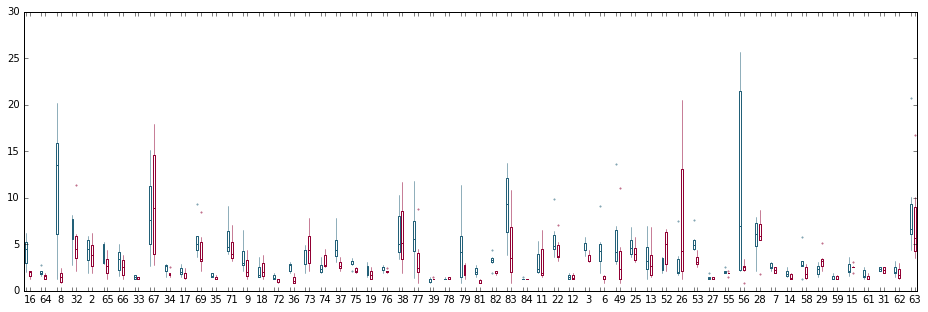

In [269]:
# Do histograms
# Go on a perline

line = 1
data = None
l = 8

xlabels = []
xpositions = []
space = 2
p = 1

for l in labels:

    jfrcHistStatFileList = findHistStatCsv( neurons, jfrcDir, l, line )
    grpHistStatFileList  = findHistStatCsv( neurons, grpDir, l, line )

    resJfrc = concatenateCentiles( jfrcHistStatFileList )
    resGrp = concatenateCentiles( grpHistStatFileList )
#     print resJfrc.shape
#     print resGrp.shape

    if( np.any( np.array(resJfrc.shape) == 0 ) ):
        #print 'skipping'
        continue

    if( np.any( np.array(resGrp.shape) == 0 )):
        #print 'skipping'
        continue
        
    if data is not None:
        if( resJfrc.shape[1] != data.shape[1] ):
            continue
        if( resGrp.shape[1] != data.shape[1] ):
            continue
        data = np.concatenate( (data,resJfrc,resGrp), axis=0 )
    else:
        data = np.concatenate( (resJfrc,resGrp), axis=0 )
    
    xlabels += [' ', str(l) ]
    xpositions += [ p, p+1 ]
    p += ( 2 + space )
    

print data.shape
print xpositions
bp = plt.boxplot( np.transpose( data ), positions=xpositions) # suppress output

fig = plt.gcf()
fig.set_size_inches( 16, 5 )

c1 = '#226078'
c2 = '#910033'
even = True
for box in bp['boxes']:
    if even:
        box.set( color=c1, linewidth=1)
    else:
        box.set( color=c2, linewidth=1)
    even = not even
    
i = 0
for w in bp['whiskers']:
    if i == 0 or i == 1:
        w.set( color=c1, linewidth=0.5, linestyle='-')
    else:
        w.set( color=c2, linewidth=0.5, linestyle='-')
    i += 1
    
    if i == 4: 
        i = 0
    
even = True
for m in bp['medians']:
    if even:
        m.set( color=c1, linewidth=1)
    else:
        m.set( color=c2, linewidth=1)
    even = not even

for c in bp['caps']:
    c.set_visible( False )
    
even = True
for flier in bp['fliers']:
    if even:
        flier.set(marker='.', markeredgecolor=c1, markerfacecolor=c1, markersize=3, alpha=0.5 )
    else:
        flier.set(marker='.', markeredgecolor=c2, markerfacecolor=c2, markersize=3, alpha=0.5 )
    even = not even
    
ax = plt.gca()
ax.set_xticklabels( xlabels )

plt.savefig('test.svg')

['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__getstate__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_axes',
 u'_axes_class',
 '_axes_locator',
 '_axisbelow',
 '_axisbg',
 '_cachedRenderer',
 '_clipon',
 '_clippath',
 '_connected',
 '_contains',
 '_current_image',
 '_cursorProps',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_get_axis_list',
 '_get_legend_handles',
 '_get_lines',
 '_get_patches_for_fill',
 '_get_view',
 '_gid',
 '_gridOn',
 '_hold',
 '_init_axis',
 '_label',
 '_left_title',
 '_make_twin_axes',
 '_mouseover',
 '_navigate',
 '_navigate_mode',
 '_oid',
 '_originalPosition',
 '_path_effects',
 '_pcolorargs',
 '_picker',
 '_

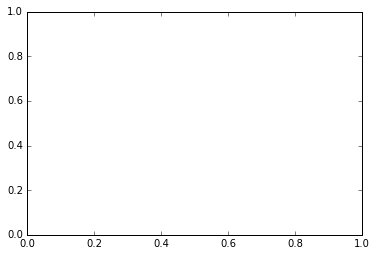

In [268]:

dir( plt.gca() )

# boxes = bp['boxes']
# b = boxes[0]
# print b 

# cap = bp['caps'][0]
# print cap
# dir( cap )

# f = bp['fliers'][0]
# print f
# dir( f )

# box = bp['boxes'][0]
# box.get_fillstyle()

#dir(box)

/nrs/saalfeld/john/projects/flyChemStainAtlas/eval/ants_jfrc2/evalComp/combined__labelHist_25_line1.csv
/nrs/saalfeld/john/projects/flyChemStainAtlas/eval_f/ants-el-ag_owl/evalComp/combined__labelHist_25_line1.csv


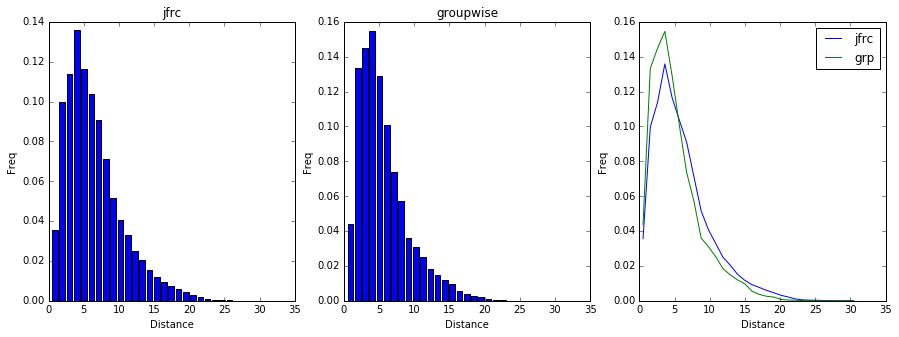

In [4]:
# Do histograms
# Go on a per-line
line = 1
label = 25

jfrcF = findHistCsv( jfrcDir,label, line)
grpF  = findHistCsv( grpDir, label, line )

print jfrcF
print grpF

jfrcH = genfromtxt( jfrcF, delimiter=',' )
grpH = normalizeHistogram( genfromtxt( grpF, delimiter=',' ))

jfrcHn = normalizeHistogram( jfrcH )
grpHn = normalizeHistogram( grpH )

plt.subplot(1,3,1)
plotHistBar( jfrcHn, 'jfrc')
plt.subplot(1,3,2)
plotHistBar( grpHn, 'groupwise' )
plt.subplot(1,3,3)
plotHistsTogether( ( jfrcHn, grpHn ), ('jfrc','grp'))

fig = plt.gcf()
fig.set_size_inches( 15, 5 )

In [5]:
print cheapHistPercentile( jfrcH, 0.2 )
print cheapHistPercentile( grpH, 0.2 )

2.58333325386
2.58333325386


In [105]:
# Load histograms 
jfrcHists = [ join( jfrcDir, f ) for f in listdir( jfrcDir ) if fnmatch.fnmatch( f, 'comb*line[0-3].csv') ]
#rpHists = [ f for f in listdir( grpDir ) if fnmatch.fnmatch( f, 'comb*line[0-3].csv') ]
len( jfrcHists )

# hist = genfromtxt( histcsv, delimiter=',' )
histcsv=jfrcHists[ 0 ]
hist = genfromtxt( histcsv, delimiter=',' )

#plotHistBar( hist, 'jfrc')

y = hist[:,1]/np.sum( hist[:,1])



In [101]:

#def hist_percentile( hist, percentile ):

(5.16666651e-01) * np.ones(100)


array([ 0.51666665,  0.51666665,  0.51666665,  0.51666665,  0.51666665,
        0.51666665,  0.51666665,  0.51666665,  0.51666665,  0.51666665,
        0.51666665,  0.51666665,  0.51666665,  0.51666665,  0.51666665,
        0.51666665,  0.51666665,  0.51666665,  0.51666665,  0.51666665,
        0.51666665,  0.51666665,  0.51666665,  0.51666665,  0.51666665,
        0.51666665,  0.51666665,  0.51666665,  0.51666665,  0.51666665,
        0.51666665,  0.51666665,  0.51666665,  0.51666665,  0.51666665,
        0.51666665,  0.51666665,  0.51666665,  0.51666665,  0.51666665,
        0.51666665,  0.51666665,  0.51666665,  0.51666665,  0.51666665,
        0.51666665,  0.51666665,  0.51666665,  0.51666665,  0.51666665,
        0.51666665,  0.51666665,  0.51666665,  0.51666665,  0.51666665,
        0.51666665,  0.51666665,  0.51666665,  0.51666665,  0.51666665,
        0.51666665,  0.51666665,  0.51666665,  0.51666665,  0.51666665,
        0.51666665,  0.51666665,  0.51666665,  0.51666665,  0.51